
# Fokker–Planck Equation, Rate Model and Learning
### Yao Lu                           

## 1. Fokker–Planck equation formalism for spiking neurons

According to some known [results](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation#Many_dimensions), for ODEs like

$$\dfrac {dv}{at}=f\left( v,t\right) +g\left( v,t\right) \xi \left( t\right) $$

where $\xi(t)$ is a standard Wiener process, there's a general formula of its Fokker-Planck equation

$$\dfrac {\partial p}{\partial t}=-\dfrac {\partial J}{\partial v} $$

$$J=f\left( v,t\right) p\left( v,t\right) -\dfrac {1}{2}\dfrac {\partial }{\partial v}g^{2}\left( v,t\right) p\left( V,t\right) $$

For a spiking neuron, the scaled version of its ODE is

$$\dfrac {dv}{dt}=-v+I\left( t\right) +b\xi \left( t\right) $$

$$v=0, \text{if}\ v > 1 $$ 

therefore we can write its FP equation as

$$\dfrac {\partial p}{\partial t}=-\dfrac {\partial J}{\partial v}-J_{1}\delta \left( v-1\right) +J_{1}\delta \left( v\right)  \label{eq1}\tag{1}$$

$$J=\left( -v+I\right) p-\dfrac {b^{2}}{2}\dfrac {\partial p}{\partial v}$$

where $J_{1}=J\left( 1,t\right) $

Due to the Wiener process, the voltage of a neuron at the firing threshold 1 will be immediately reset to 0, therefore

$$A\left( t\right) =J\left( 1,t\right) =-\dfrac {b^{2}}{2}\dfrac {\partial p}{\partial v}\left( 1,t\right) \label{eq2}\tag{2}$$

where $A(t)$ is the firing rate.

## 2. Origin of Wiener Process

Where does the $\xi(t)$ come from? We can argue that the internel environment of a cell is noisy, but a more plausible explanation is that $\xi(t)$ comes from the interaction between a neuron and thousands of other neurons.

Use $A(t)$ to denote the firing rate or activity of a presynaptic population of a particular neuron, then the firing probability of a presynaptic neuron in $\Delta t $ is $p\left( t\right) =A\left( t\right) \Delta t$. $N$ is the size of the presynaptic population and $N_{spike}$ is the total number of neurons in this population that has fired in $\Delta t$. Assume that each neuron fires independently, then 

$$\langle  N_{spike}\rangle  =N p$$


$$Var\left( N_{spike}\right) =Np\left( 1-p\right) ≈Np$$

$\Delta v$ is the increment of voltage in $\Delta t$ caused by synaptic inputs, $w$ is the average weight of presynapse, and $\tau_{s}$ is the time constant of synaptic current.

$$\langle  \Delta v\rangle  =\langle  \tau _{s} w N_{spike}\rangle  =NAw\tau_{s}\Delta t \label{eq3}\tag{3}$$


$$Var\left( \Delta v\right) = Var\left(\tau _{s}wN_{spike} \right) = \tau_{s}^{2}w^{2}NA\Delta t$$

According to the definition of Wiener process, $$Var\left( \Delta v\right) =b^{2}\Delta t$$ therefore $$b^{2}=W^{2}\tau ^{2}_{s}NA \label{eq4}\tag{4}$$

## 3. Numerical solutions to the FP equation of a spiking neuron

Although it could be possible to find stationary solutions to \ref{eq1} in some special cases \cite{gerstner2014neuronal}, it's difficult to solve it analytically for general cases. Moreover, the primal objective of writing down the FP equations for scientific phenomena is to enhance our understanding, not to solve them. Here, we use simulations to understand the dynamics of spiking networks. Here, we use [SNN.jl](https://github.com/AStupidBear/SNN.jl) to simulate.

In [1]:
import Plots, Utils
Plots.default(size=(600, 300), html_output_format="png")
reload("SNN")

We use 1000 neurons for our simulation.

In [2]:
N = 1000

1000

Create a IF(Integrate and Fire) neuron group with $b=0.8$, $I=1.01$, and other parameters the same as \ref{eq1}.

In [3]:
G = SNN.NoisyIF(N; τm=1, Vt=1, Vr=0, El=0, σ=0);
fill!(G.I, 1.01);

Record spiking times and voltages of $G$.

In [4]:
Utils.monitor(G, [:fire, :v])

Simulate $G$ for 30 ms.

In [5]:
SNN.sim!([G], []; duration=30)

The following raster plot shows the spiking times of each neuron. 


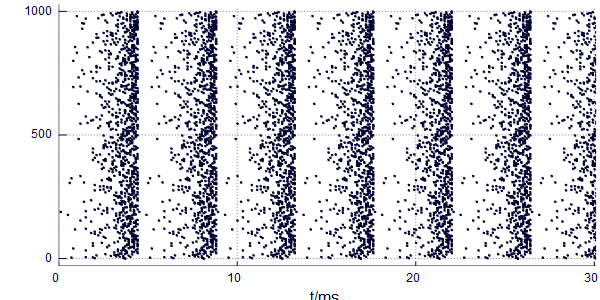

In [6]:
SNN.raster([G])

In the following gif shows the evolution of population density of $G$, ie the time dependent solution to FP equation.

In [11]:
G = SNN.NoisyIF(N; τm=1, Vt=1, Vr=0, El=0, σ=0.8)
fill!(G.I, 1.01)
G.v = -1.5 + rand(N)
Utils.monitor(G, [:fire, :v])
SNN.sim!([G], []; duration=3)
SNN.density(G, :v)

INFO: Saved animation to C:\Users\AStupidBear\Documents\Julia\Notebooks\tmp.gif


Plots.AnimatedGif("C:\\Users\\AStupidBear\\Documents\\Julia\\Notebooks\\tmp.gif")

As you can see, due to the effect of $\delta$ function in \ref{eq1}, there'a discontinuity of flux $J(v)$ at $v=0$, therefore the derivative of $p$ at 0 is very large (but $p(v)$ is continous because $J(v)$ must be finite)

There are two adjustable parameters in our system, current $I$ and noise $\sigma$. If both $I$ and $\sigma$ are time invariant, we can get the relationship between stationary population activity $A$ and $(I, b)$.

In [8]:
function rate(I::Number, σ::Number)
  N = 1000
  G = SNN.NoisyIF(N; τm=1, Vt=1, Vr=0, El=0, σ=σ)
  fill!(G.I, I)
  Utils.monitor(G, [:fire])
  SNN.sim!([G], []; duration=100)
  A = sum.(G.records[:fire])/G.N/SNN.dt
  mean(A[end÷2:end])
end

rate (generic function with 1 method)

<a name="A-I curve"></a>


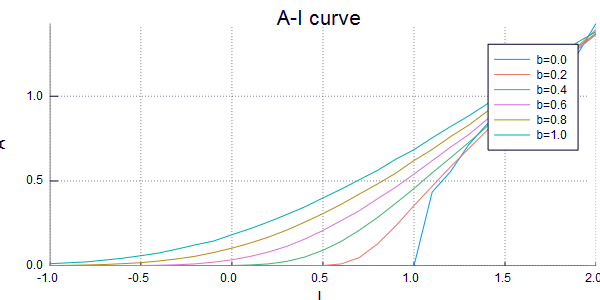

In [9]:
I = -1:0.1:2
p = Plots.plot(xlabel="I", ylabel="A", title="A-I curve")
for σ = 0:0.2:1
  A = rate.(I, σ)
  Plots.plot!(p, I, A, label="b=$σ")
end
p

## 4. Training SNN (spiking neural networks) using results of FP equation

In recent years, there have been tons of methods developed for training RNN (recurrent neural networks), but there are really few effective methods for training SNN. Compared to RNN, SNN are more biologically plausible, computationally efficient, and better at preserving local causality. 

Therefore, it will be great that we can transform a rate network pretrained by methods for RNN to spiking networks. The common procetures are:
- Pretrain a rate network using [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time), Force Learning 
\cite{Davi-2009}, etc.
- Transform the rate network to a spiking network based on the A-I curve calculated by solving FP-equation. Each rate unit will be represented by a group of spiking neurons.
- Using other supervised or unsupervised (such as [STDP](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity)) training rules to refine the spiking network.

However, there are several difficulties: 
- During pretraining, the [A-I curve](#A-I curve) is usually fixed. We know that the A-I curve is also affected by gaussian noises, originated from presynaptic currents, therefore this relationship is non-local. How can we configure this group to match the A-I curve fixed for pre-training and A-I curve of the group?
- Experically speaking, SNN are usually 20 times faster thant RNN. To maintain the computational efficiency, we have to restrict the population size for every unit to be much less than 20. With so few neurons, how can we accurately recover the original firing rate?

This is still a work in progress, but it's promising.

# References

(<a id="cit-gerstner2014neuronal" href="#call-gerstner2014neuronal">Gerstner, 2014</a>) Wulfram Gerstner, ``_Neuronal dynamics : from single neurons to networks and models of cognition_'',  2014.

(<a id="cit-Davi-2009" href="#call-Davi-2009">David Sussillo, 2009</a>) David Sussillo L.F. Abbott, ``_Generating Coherent Patterns of Activity from Chaotic Neural Networks_'', Neuron, vol. 63, number , pp. ,  2009.  [online](http://gen.lib.rus.ec/scimag/index.php?s=10.1016/j.neuron.2009.07.018)

